In [1]:
import cv2
import random
import time
import numpy as np
from scipy import misc

from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
import os
import sys
sys.path.append('../common/')
import utils

In [2]:
import pickle

In [3]:
import pickle
with open('./xy.pkl','rb') as whdl:
    (IM_train,y_train,IM_test) = pickle.load(whdl)

In [4]:
len(IM_train),len(y_train)

(58512, 58512)

# 定义两个通用函数

In [5]:
def translate(image, x, y):
    M = np.float32([[1, 0, x], [0, 1, y]])
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return shifted
def calculate_histogram(array,weights,bins=9):
    bins_range = (-75, 75)
    hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)
    return hist

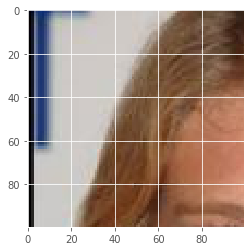

In [6]:
sample_image = IM_train[0]
plt.imshow(np.asarray(sample_image,dtype=np.uint8))

In [7]:
sample_image.shape

(100, 100, 3)

# HOG特征第一步：转灰度图

In [8]:
sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY)

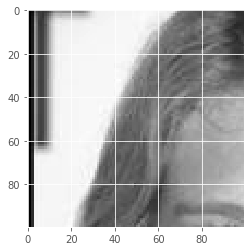

In [9]:
plt.imshow(sample_image,cmap='gray')

In [10]:
sample_image.reshape(-1).shape

(10000,)

# HOG特征第二步：图片数值取平方根

In [11]:
sample_image = sample_image ** 0.5

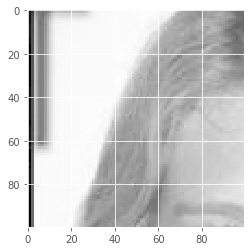

In [12]:
plt.imshow(sample_image,cmap='gray')

# HOG特征第二步（1）：计算X和Y方向梯度

In [13]:
import pandas as pd

In [14]:
GX = translate(sample_image,1,0) - translate(sample_image,-1,0)
GY = translate(sample_image,0,1) - translate(sample_image,0,-1)

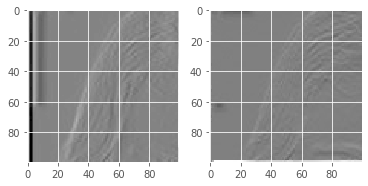

In [15]:
plt.subplot(1,2,1)
plt.imshow(GX,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(GY,cmap='gray')

# HOG特征第二步（2）：计算每个点梯度的角度和大小

In [16]:
delta_G = np.sqrt(GX ** 2 + GY ** 2)
angle = np.arctan(GY / GX) / np.pi * 180

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arctan
  


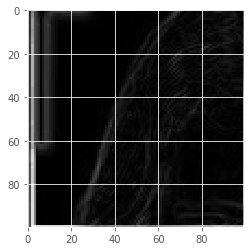

In [17]:
plt.imshow(delta_G,cmap='gray')

In [18]:
delta_G.shape,angle.shape

((100, 100), (100, 100))

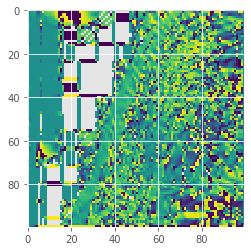

In [19]:
plt.imshow(angle)

# HOG特征第四步： 计算特征直方图

In [20]:
features = np.zeros((4,4,9))
for i in range(0,100,25):
    for j in range(0,100,25):
        features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],delta_G[i:i + 25,j:j + 25])
        

/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [21]:
features.shape

(4, 4, 9)

In [22]:
features[0,0]

array([  8.53388517,   2.42423591,   4.10806972,  21.90869273,
       812.61538146,  75.29226967,  14.922042  ,  23.21957435,
        18.97036356])

# HOG特征第五步： 归一化

In [23]:
one_feature = []
for i in range(3):
    for j in range(3):
        mat_norm = features[i:i + 2,j:j + 2] # (2 * 2 * 9) - > (36)
        mag = np.linalg.norm(mat_norm)
        arr_list = (mat_norm / mag).flatten().tolist()  # flatten == reshape(-1)
        one_feature += arr_list

In [24]:
len(one_feature)

324

# 整个过程review

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in arctan


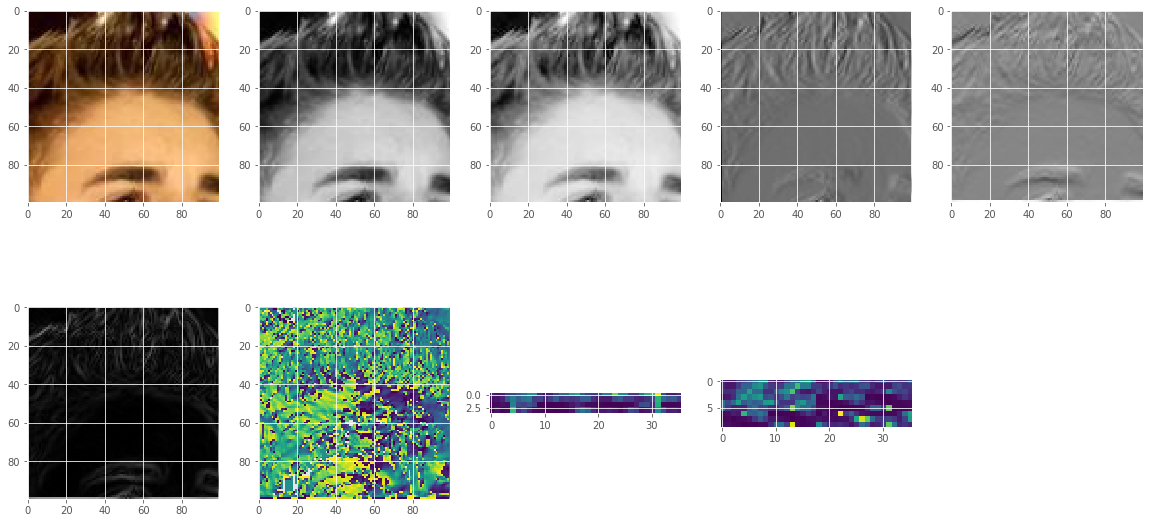

In [25]:
plt.figure(figsize=(20,10))

sample_image = IM_train[-200]
plt.subplot(2,5,1)
plt.imshow(sample_image)


# STEP 1 convert to gray
sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY)
plt.subplot(2,5,2)
plt.imshow(sample_image,cmap='gray')


# STEP 2 normalize
sample_image = sample_image ** 0.5
plt.subplot(2,5,3)
plt.imshow(sample_image,cmap='gray')

# STEP 3 calculate GX,GY
GX = translate(sample_image,1,0) - translate(sample_image,-1,0)
plt.subplot(2,5,4)
plt.imshow(GX,cmap='gray')

GY = translate(sample_image,0,1) - translate(sample_image,0,-1)
plt.subplot(2,5,5)
plt.imshow(GY,cmap='gray')

# STEP 4 calculate DELTA G and angle
delta_G = np.sqrt(GX ** 2 + GY ** 2)
plt.subplot(2,5,6)
plt.imshow(delta_G,cmap='gray')

angle = np.arctan(GY / GX) / np.pi * 180
plt.subplot(2,5,7)
plt.imshow(angle)

delta_G[angle == 0] = 0

# step 5 calcalute features
features = np.zeros((4,4,9))
for i in range(0,100,25):
    for j in range(0,100,25):
        features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],delta_G[i:i + 25,j:j + 25])
        
plt.subplot(2,5,8)
plt.imshow(features.reshape(4,36))

# step 6 local normalize
one_feature = []
for i in range(3):
    for j in range(3):
        mat_norm = features[i:i + 2,j:j + 2]
        mag = np.linalg.norm(mat_norm)
        arr_list = (mat_norm / mag).flatten().tolist()
        one_feature += arr_list
plt.subplot(2,5,9)
plt.imshow(np.asarray(one_feature).reshape(9,-1))

# 定义抽取特征函数

In [26]:

def extrace_feature(sample_image):
    sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY)



    # STEP 2 normalize
    sample_image = sample_image ** 0.5


    # STEP 3 calculate GX,GY
    GX = translate(sample_image,1,0) - translate(sample_image,-1,0)


    GY = translate(sample_image,0,1) - translate(sample_image,0,-1)


    # STEP 4 calculate DELTA G and angle
    delta_G = np.sqrt(GX ** 2 + GY ** 2)


    angle = np.arctan(GY / GX) / np.pi * 180


    delta_G[angle == 0] = 0

    # step 5 calcalute features
    features = np.zeros((4,4,9))
    for i in range(0,100,25):
        for j in range(0,100,25):
            features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],delta_G[i:i + 25,j:j + 25])

    # step 6 local normalize
    one_feature = []
    for i in range(3):
        for j in range(3):
            mat_norm = features[i:i + 2,j:j + 2]
            mag = np.linalg.norm(mat_norm)
            arr_list = (mat_norm / mag).flatten().tolist()
            one_feature += arr_list
    return one_feature

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arctan


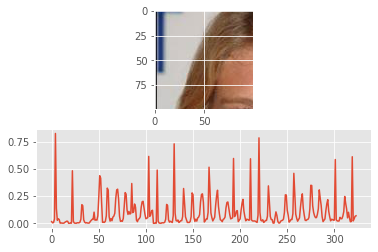

In [27]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])

plt.subplot(2,1,1)
plt.imshow(IM_train[0])
plt.subplot(2,1,2)
plt.plot(extrace_feature(IM_train[0]))

# 抽取特征

In [28]:
from collections import Counter

In [29]:
Counter(y_train)

Counter({0: 55755, 1: 2757})

In [30]:

pb = utils.ProgressBar(worksum=len(IM_train))
pb.startjob()
features = []
targets = []
for one_image,one_target in zip(IM_train,y_train):
    one_feature = []
    if len(one_image.shape) != 3:
        continue
    if one_target == 0 and random.random() > 0.2:
        pb.complete(1)
        continue
    features.append(extrace_feature(one_image))
    targets.append(one_target)
    pb.complete(1)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arctan


 12.64 % [======>--------------------------------------------] 7393/58512 	 used:5s eta:36 s

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


 99.76 % [=================================================>-] 58371/58512 	 used:43s eta:0 ss

In [31]:
len(features),len(targets)

(13857, 13857)

In [32]:
Counter(targets)

Counter({0: 11106, 1: 2751})

In [33]:
train_x,val_x = features[:-2000], features[-2000:]
train_y,val_y = targets[:-2000], targets[-2000:]

In [34]:
import sklearn
from sklearn.svm import SVC

In [35]:
svm = SVC(probability=True)

In [36]:
train_x = np.nan_to_num(train_x,0)

In [37]:
svm_model = svm.fit(train_x,train_y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [38]:
val_x = np.nan_to_num(val_x,0)

In [39]:
val_pred = svm_model.predict_proba(val_x)[:,1]

In [40]:
import pandas as pd

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4bb15ed90>]],
      dtype=object)

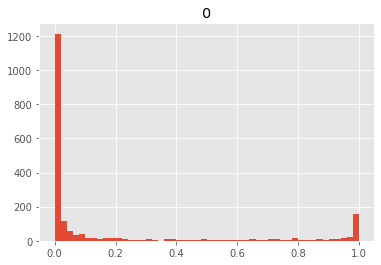

In [41]:
pd.DataFrame(val_pred).hist(bins=50)

# 查看AUC

In [42]:
from sklearn import metrics

In [43]:
 fpr, tpr, thresholds = metrics.roc_curve(val_y, val_pred, pos_label = 1)

In [44]:
metrics.auc(fpr, tpr)

0.9616324233042499

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in arctan
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning:

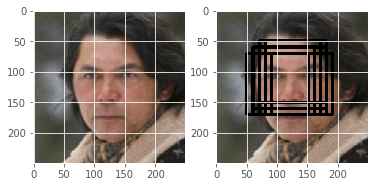

In [45]:

sample_image = np.copy(IM_test[0])
plt.subplot(1,2,1)
plt.imshow(sample_image)
for i in range(0,250 - 100,10):
    for j in range(0,250 - 100,10):
        one_feature = extrace_feature(sample_image[i:i + 100,j:j + 100])
        one_feature = np.nan_to_num(one_feature,0)
        result = svm_model.predict_proba([one_feature])
        #print(result)
        if result[0][1] > 0.5:
            cv2.rectangle(sample_image,(i,j),(i + 100,j + 100),(0,0,0),3)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [46]:
result

array([[0.99425504, 0.00574496]])